In [24]:
import csv
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
from scipy.stats import norm

In [25]:
D=[]
for i in [1,3,4,5,6,7,8,9]:
    data_file='demo' + str(i) +'.csv'
    data = np.loadtxt(data_file,delimiter=',')[10:]
    D.append(data)

In [37]:
def plot_setpoints(seq1,dmax,dmin):   
    # initialize figure
    fig = plt.figure(figsize = (10,3))
 
    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1,1) 
    ax1 = plt.subplot(gs[0]);
 
    # plot
    ax1.plot(np.arange(np.size(seq1)),seq1,c = 'k',linewidth = 2.5,linestyle ='-')
    ax1.plot([dmax]*np.size(np.arange(0,np.max(copy.deepcopy(seq1)),0.01)),np.arange(0,np.max(copy.deepcopy(seq1)),0.01),c='r',linewidth=1.0, linestyle ='--')
    ax1.plot([dmin]*np.size(np.arange(0,np.max(copy.deepcopy(seq1)),0.01)),np.arange(0,np.max(copy.deepcopy(seq1)),0.01),c='b',linewidth=1.0, linestyle ='--')

    # label axes and title
    ax1.set_ylabel('velocity (m/s)')
    ax1.set_xlabel('timestamp')
    
    # set viewing limits
    s1min = np.min(copy.deepcopy(seq1))
    s1max = np.max(copy.deepcopy(seq1))
    s1gap = (s1max - s1min)*0.1
    s1min -= s1gap
    s1max += s1gap
    ax1.set_ylim([s1min,s1max])
 
    plt.show()

In [38]:
sampling_rate= 10
time = 1/sampling_rate
def get_velocities(data,window_size=5,step_size=1):
    velocity=[]
    ee_pos=data[:,:3]
    j=0
    while j< len(ee_pos):
        window = ee_pos[j:j+window_size]
        v_list=[]
        for k in range(len(window)-1):
            a= window[k]
            b= window[k+1]
            dis = sqrt((a[0]-b[0])**2+(a[1]-b[1])**2+(a[2]-b[2])**2)
            v = dis / time
            v_list.append(v)
        if v_list != []:
            v_avg=np.average(v_list)
            velocity.append(v_avg)
        j+=step_size
    return velocity

def find_dmax(data,check_size=15):
    peak = np.max(data) * (1/3)
    
    epsilon = 0.05
    for i in range(len(data)):
        if data[i] >= peak - epsilon and data[i] <= peak + epsilon:
            return (i)
#     diff=np.diff(v)
#     grow=diff>0
#     flag = False
#     for i in range(len(grow)-check_size):
#         if grow[i] == True:
#             flag= True
#             for j in range(1,check_size+1):
#                 if grow[i+j] == False and data[i+j+1]<=data[i+1]:
#                     flag = False
#         if flag:
#             return (i+1)
        
def find_dmin(data,dmax_t,check_size=15):
    return np.argmax(data)+1
    

#     diff=np.diff(v)
#     grow=diff<0
#     flag = False
#     for i in range(dmax_t,len(grow)-check_size):
#         if grow[i] == True:
#             flag= True
#             for j in range(1,check_size+1):
#                 if grow[i+j] == False and data[i+j+1]>=data[i+1]:
#                     flag = False
#         if flag:
#             return (i)

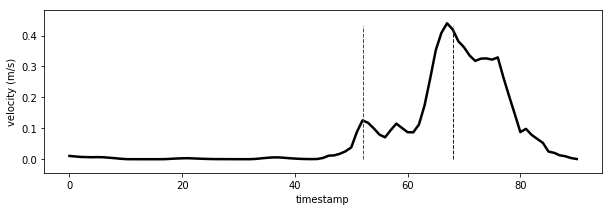

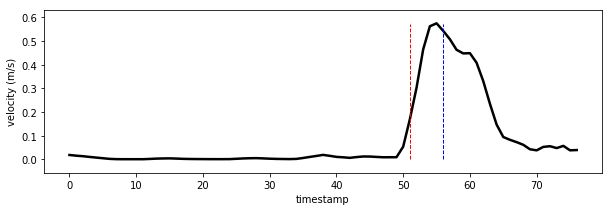

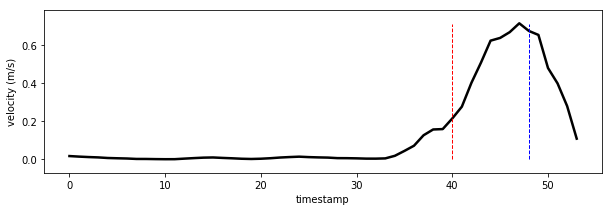

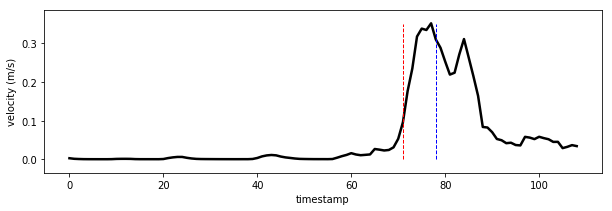

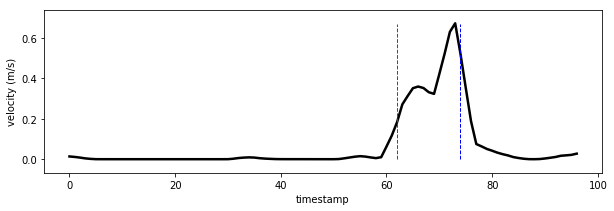

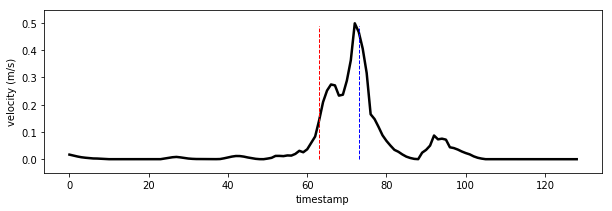

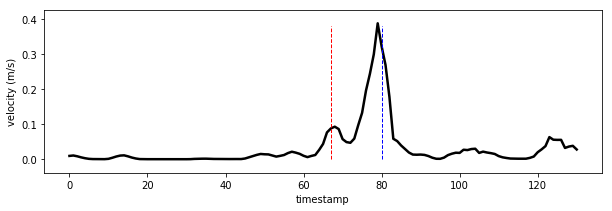

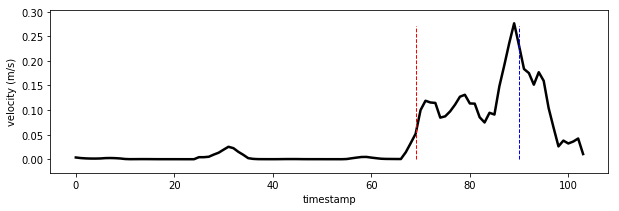

In [39]:
dmax_t_list=[]
dmin_t_list=[]
for i in range(len(D)):
    v= get_velocities(D[i])
    dmax_t=find_dmax(v)
    dmin_t=find_dmin(v,dmax_t)
    plot_setpoints(v,dmax_t,dmin_t)
    dmax_t_list.append(dmax_t)
    dmin_t_list.append(dmin_t)
#     dis=[]
#     for j in range(len(D[i])):
#         a = D[i][j][:3]
#         b = D[i][j][3:]
#         dis.append(sqrt((a[0]-b[0])**2+(a[1]-b[1])**2))
#     plot_setpoints(dis,0,0)

In [29]:
dmax_list=[]
dmin_list=[]
l_x_list=[]
l_y_list=[]
for i in range(len(D)):
    l_x_list_=[]
    l_y_list_=[]
    poses=D[i]
    dmax_pos = poses[dmax_t_list[i]]
    a = dmax_pos[:3]
    b = dmax_pos[3:]
    dmax = sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
    dmax_list.append(dmax)
    dmin_pos = poses[dmin_t_list[i]]
    a = dmin_pos[:3]
    b = dmin_pos[3:]
    dmin = sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
    dmin_list.append(dmin)
    
    valid_pos=poses[dmax_t_list[i]:dmin_t_list[i]]
    p_re = valid_pos[:,:3]
    p_rh = valid_pos[:,3:]
    for i in range(len(p_re)):
        l_x = p_re[i][0] - p_rh[i][0]
        l_y = p_re[i][1] - p_rh[i][1]
        l_x_list_.append(l_x)
        l_y_list_.append(l_y)
    l_x_list.append(np.average(l_x_list_))
    l_y_list.append(np.average(l_y_list_))

In [30]:
dmax_mu, dmax_k= norm.fit(dmax_list)
dmin_mu, dmin_k= norm.fit(dmin_list)
lx_mu, lx_k= norm.fit(l_x_list)
ly_mu, ly_k= norm.fit(l_y_list)

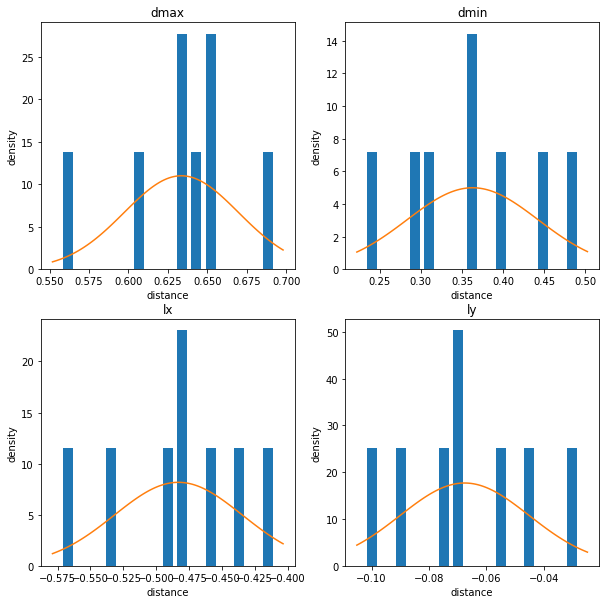

In [62]:
fig = plt.figure(figsize = (10,10))
    
ax1 = plt.subplot(221)
ax1.hist(dmax_list, bins=15,density=True,rwidth=0.7)
xmin1, xmax1 = plt.xlim()
ax1x = np.linspace(xmin1, xmax1, 100)
ax1y = norm.pdf(ax1x, dmax_mu, dmax_k)
ax1.plot(ax1x, ax1y)
ax1.set_ylabel('density')
ax1.set_xlabel('distance')
ax1.set_title('dmax')


ax2 = plt.subplot(222)
ax2.hist(dmin_list, bins=15,density=True,rwidth=0.7)
xmin2, xmax2 = plt.xlim()
ax2x = np.linspace(xmin2, xmax2, 100)
ax2y = norm.pdf(ax2x, dmin_mu, dmin_k)
ax2.plot(ax2x, ax2y)
ax2.set_ylabel('density')
ax2.set_xlabel('distance')
ax2.set_title('dmin')

ax3 = plt.subplot(223)
ax3.hist(l_x_list, bins=15,density=True,rwidth=0.7)
xmin3, xmax3 = plt.xlim()
ax3x = np.linspace(xmin3, xmax3, 100)
ax3y = norm.pdf(ax3x, lx_mu, lx_k)
ax3.set_ylabel('density')
ax3.set_xlabel('distance')
ax3.set_title('lx')
ax3.plot(ax3x, ax3y)

ax4 = plt.subplot(224)
ax4.hist(l_y_list, bins=15,density=True,rwidth=0.7)
xmin4, xmax4 = plt.xlim()
ax4x = np.linspace(xmin4, xmax4, 100)
ax4y = norm.pdf(ax4x, ly_mu, ly_k)
ax4.set_ylabel('density')
ax4.set_xlabel('distance')
ax4.set_title('ly')
ax4.plot(ax4x, ax4y)

plt.show()

In [32]:
print(dmax_mu, dmax_k, '\n', dmin_mu, dmin_k, '\n', lx_mu, lx_k, '\n',ly_mu, ly_k)

0.6335226563066152 0.036305592347642544 
 0.3629434249264483 0.07987559327852922 
 -0.4830821729094042 0.048826929517971095 
 -0.06755893564515598 0.02255958966626023


In [33]:
print(dmax_mu - dmax_k, dmax_mu + dmax_k, '\n',dmin_mu-dmin_k, dmin_mu+dmin_k, '\n',lx_mu-lx_k, lx_mu+lx_k,'\n', ly_mu-ly_k, ly_mu+ly_k)

0.5972170639589727 0.6698282486542577 
 0.2830678316479191 0.44281901820497754 
 -0.5319091024273753 -0.4342552433914331 
 -0.09011852531141622 -0.04499934597889575
